<h1 align='center'> Glean CV Approach </h1>
We are going to see how we can try Computer Vision Approach to Classify various vendors. The idea is to use EfficientNetB0 to train on the images of first pages of all pdf documents.

In [1]:
from utilities import *
from PIL import Image
import tensorflow as tf
from keras.applications.efficientnet import EfficientNetB0
from sklearn.model_selection import train_test_split


<h3> Getting Dataset </h3>

Initially our files are present as pdf we are going to conver them into images. We are taking the  first page of each pdf file and using it to get the image from that page and going to train only on those  

In [6]:
#path_of_dataset=input('Enter the path of the dataset to start working on: ')
X,Y,map=prepare_all_dataset('../Dataset')#path_of_dataset)
n_class=len(list(set(Y)))
X=get_images_array(X)
Y=np.asarray(Y)
print(map)
dump_load_map(map,0)

Y=tf.keras.utils.to_categorical(
    Y, num_classes=n_class, dtype='float32')
X_train,X_test,Y_train,Y_test=train_test_split(X,Y)

Here are vendors: ['../Dataset/Aws', '../Dataset/DHL', '../Dataset/Google', '../Dataset/Medline', '../Dataset/Plaid_Inc', '../Dataset/Total_Quality_Logistics']

Aws vendor Processing 


dirs: 100%|██████████| 49/49 [00:00<00:00, 96.16it/s]



DHL vendor Processing 


dirs: 100%|██████████| 89/89 [00:00<00:00, 154.24it/s]



Google vendor Processing 


dirs: 100%|██████████| 90/90 [00:00<00:00, 146.56it/s]



Medline vendor Processing 


dirs: 100%|██████████| 100/100 [00:01<00:00, 94.99it/s]



Plaid_Inc vendor Processing 


dirs: 100%|██████████| 100/100 [00:00<00:00, 138.20it/s]



Total_Quality_Logistics vendor Processing 


dirs: 100%|██████████| 100/100 [00:01<00:00, 71.97it/s]


{'Aws': 0, 'DHL': 1, 'Google': 2, 'Medline': 3, 'Plaid_Inc': 4, 'Total_Quality_Logistics': 5}


<h3> Creating Architecture of EffiicnetNetB0 </h3>

In [11]:
def Custom_Efficient_Net(image_shape=X[0].shape,output_shape=n_class):
    if 'Efficient_net_custom.h5' in os.listdir(os.getcwd()):
        print('Loaded Previous Model ')
        model=tf.keras.models.load_model('Efficient_net_custom.h5')
    else: 
        input_val=tf.keras.layers.Input(shape=image_shape)
        model=EfficientNetB0(include_top=False,input_tensor=input_val,weights='imagenet')

        for i in range(int(len(model.layers) * 0.75)):
            model.layers[i].trainable = False

        #model.trainable = False


        x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
        x = tf.keras.layers.BatchNormalization()(x)

        top_dropout_rate = 0.2
        x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
        #x=tf.keras.layers.Flatten()
        output = tf.keras.layers.Dense(output_shape, activation="softmax", name="pred")(x)

        model=tf.keras.Model(inputs=input_val,outputs=output)
    
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

custom_model=Custom_Efficient_Net()

<h3> Training The Model </h3>

In [12]:
callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',mode='auto',restore_best_weights=True )
hist=custom_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,callbacks=[callback],batch_size=128)

Epoch 1/100
2/2 [==============================] - 9s 3s/step - loss: 1.3734 - accuracy: 0.5025 - val_loss: 1.6657 - val_accuracy: 0.2537
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 0.0402 - accuracy: 0.9849 - val_loss: 1.5590 - val_accuracy: 0.2239
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.0077 - accuracy: 0.9950 - val_loss: 1.4889 - val_accuracy: 0.2388
Epoch 4/100
2/2 [==============================] - 4s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.4335 - val_accuracy: 0.2388
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3828 - val_accuracy: 0.2537
Epoch 6/100
2/2 [==============================] - 4s 2s/step - loss: 7.0613e-04 - accuracy: 1.0000 - val_loss: 1.3324 - val_accuracy: 0.2687
Epoch 7/100
2/2 [==============================] - 4s 2s/step - loss: 1.2018e-04 - accuracy: 1.0000 - val_loss: 1.2816 - val_accuracy: 0.2836
Epoch 8/100
2/2 [=========

<h3> Saving Model and plotting the graphs </h3>

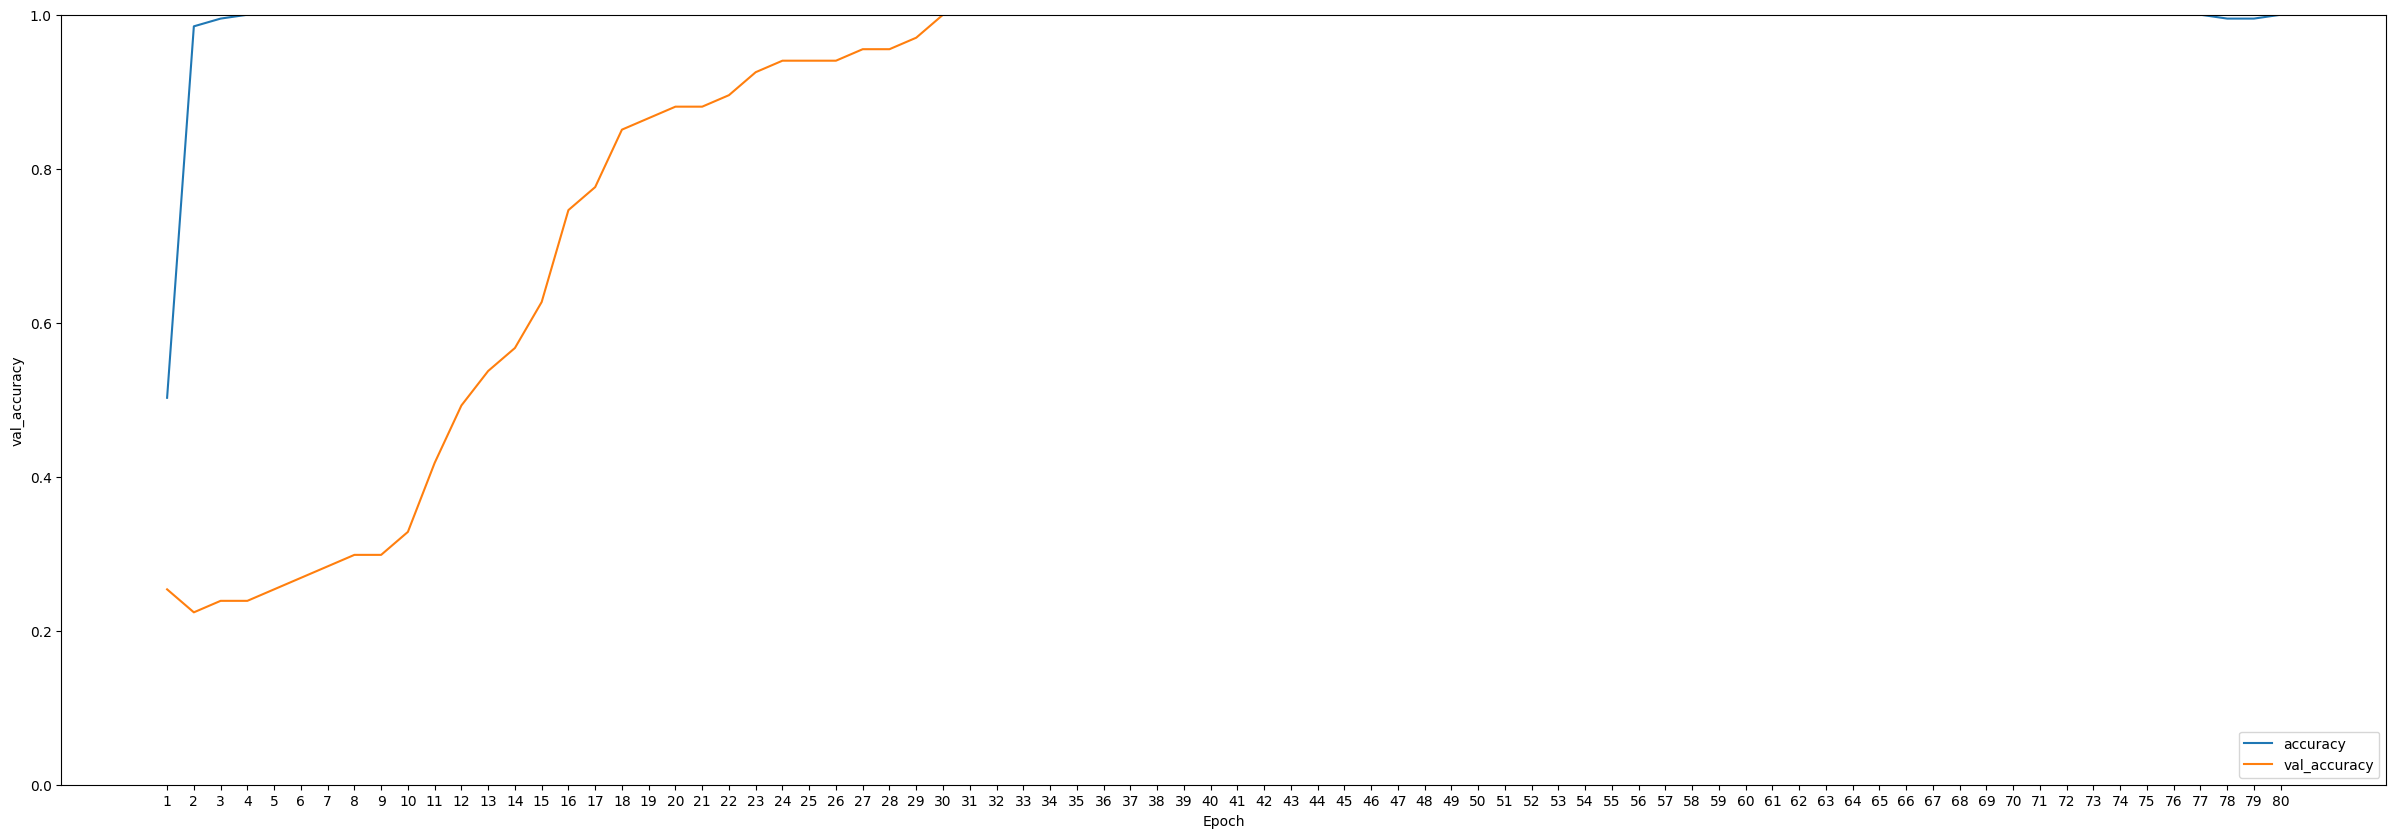

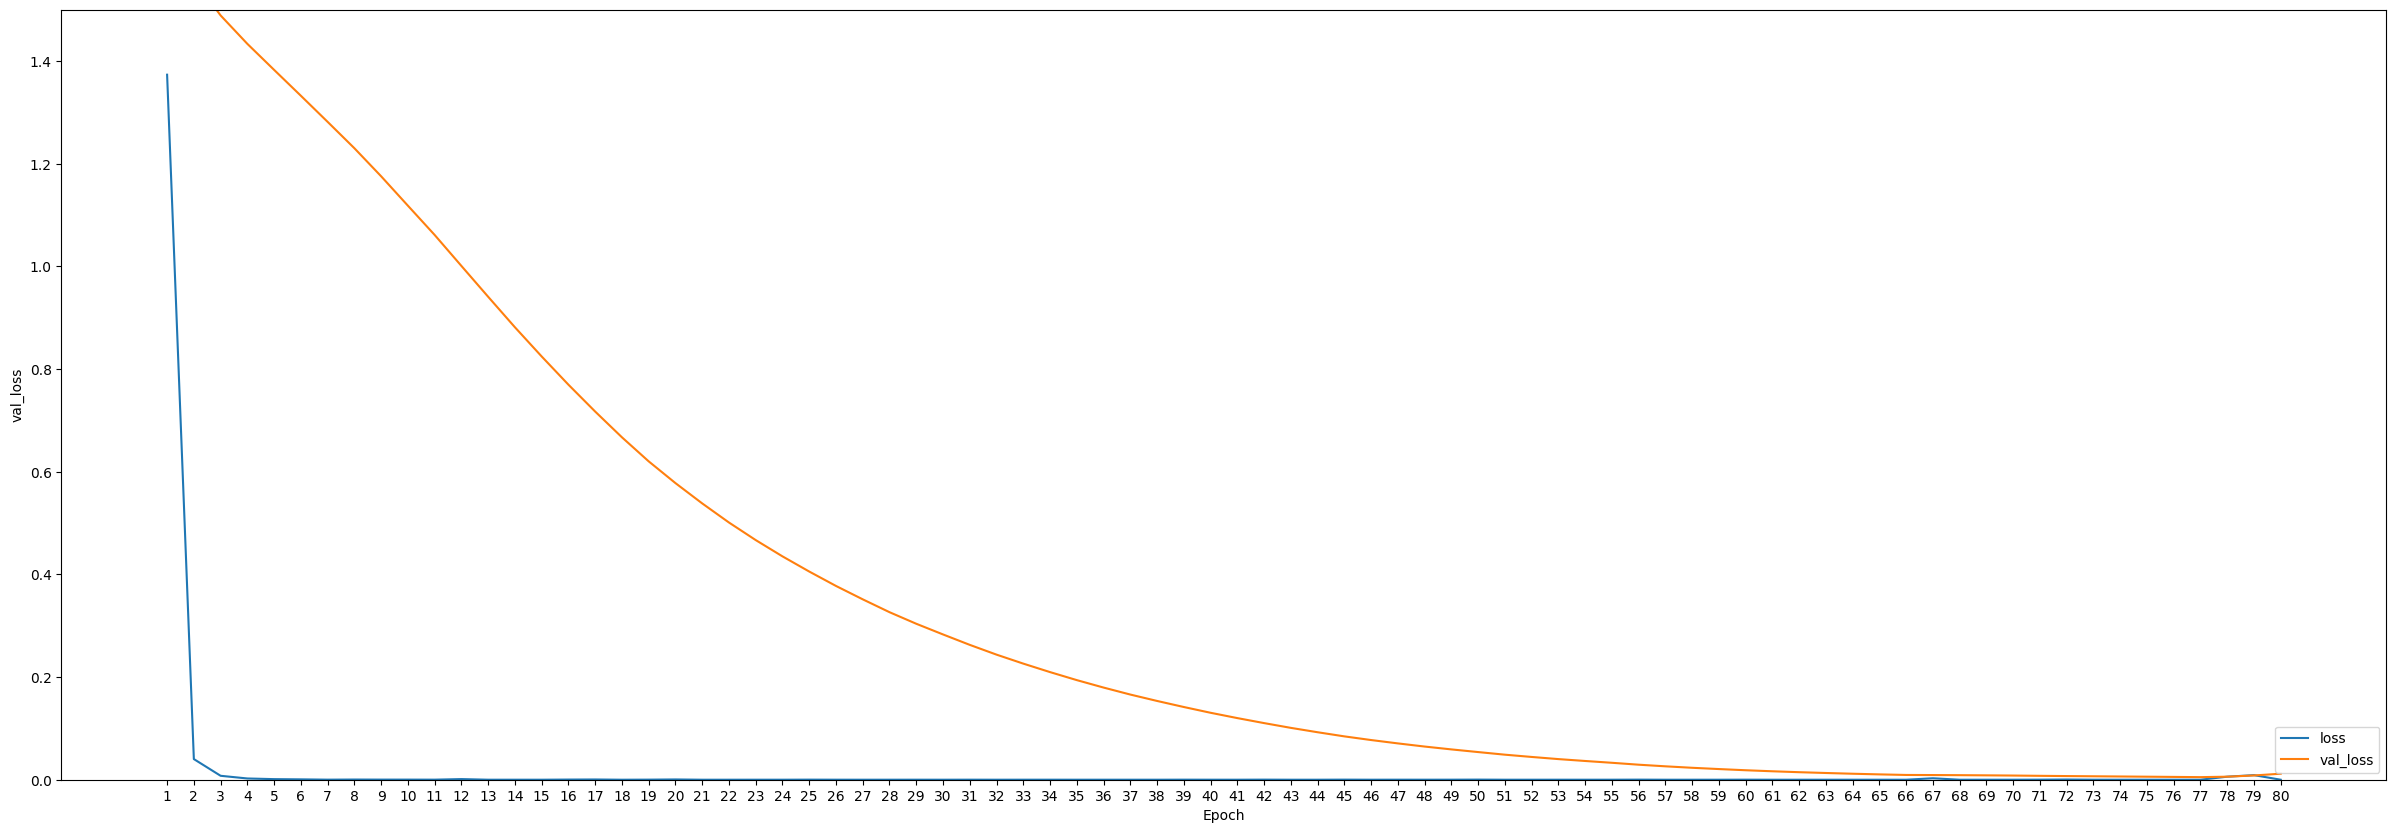

In [13]:
custom_model.save('Efficient_net_custom.h5')
plot_metrics_for_training(hist.history)

<h3> Inference testing </h3>



In [4]:
#D:\Fuse_Work\Glean_Experiments\Dataset\Medline\01GH7C1RYM86F7JDQFJ1944V84.pdf
loaded_model=tf.keras.models.load_model('Efficient_net_custom.h5')
map=dump_load_map({},1)
path_image=input('Enter PDF Path: ')
test_img=inference_image_get(path_image)
preds=loaded_model.predict(test_img.reshape(1,test_img.shape[0],test_img.shape[1],test_img.shape[2]))
op=np.argmax(preds)
print(list(preds[0])[op])
if list(preds[0])[op]<=0.85:
    print('This file belongs to none of the vendors ')
else: 
    print(list(filter(lambda x: map[x] == op, map))[0])

1/1 [==============================] - 1s 740ms/step
0.39048925
This file belongs to none of the vendors 
